# Importing libraries

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from Handler.cut_functions import *
from datetime import datetime
import sys
import yaml
import argparse
import pandas as pd
import os
from scipy.stats import gaussian_kde

In [115]:
%matplotlib inline

# Set system path

In [116]:
current_dir = os.getcwd()
sys.path.append(current_dir)
path = os.path.abspath(sys.path[-1])

# Reading the configuration file

In [117]:
if get_os() == "Mac":
    config_file_name = "mac.cfg"
elif get_os() == "Windows":
    config_file_name = "windows.cfg"
elif get_os() == "Linux":
    config_file_name = "LMU.cfg"
else:
    raise f"OS Error: {get_os()}"

parser = argparse.ArgumentParser(description='Start create balrog training dataset')
parser.add_argument(
    '--config_filename',
    "-cf",
    type=str,
    nargs=1,
    required=False,
    default=config_file_name,
    help='Name of config file'
)
args, unknown = parser.parse_known_args()

if isinstance(args.config_filename, list):
    args.config_filename = args.config_filename[0]

with open(f"{path}/config/{args.config_filename}", 'r') as fp:
    cfg = yaml.load(fp, Loader=yaml.Loader)

In [118]:
now = datetime.now()
cfg['RUN_DATE'] = now.strftime('%Y-%m-%d_%H-%M')

# Define some functions

In [119]:
def apply_cuts(cfg, data_frame, mag_cut=True, prob=False):
    """"""
    if mag_cut is True:
        data_frame = unsheared_object_cuts(data_frame=data_frame, prob=prob)
        data_frame = flag_cuts(data_frame=data_frame, prob=prob)
        data_frame = unsheared_shear_cuts(data_frame=data_frame, prob=prob)
        data_frame = binary_cut(data_frame=data_frame, prob=prob)
        data_frame = mask_cut(data_frame=data_frame, master=f"{cfg['PATH_DATA']}/{cfg['FILENAME_MASTER_CAT']}", prob=prob)
        data_frame = unsheared_mag_cut(data_frame=data_frame)
    elif mag_cut is False:
        data_frame = unsheared_object_cuts(data_frame=data_frame, prob=prob)
        data_frame = flag_cuts(data_frame=data_frame, prob=prob)
        data_frame = unsheared_shear_cuts(data_frame=data_frame, prob=prob)
        data_frame = binary_cut(data_frame=data_frame, prob=prob)
        data_frame = mask_cut(data_frame=data_frame, master=f"{cfg['PATH_DATA']}/{cfg['FILENAME_MASTER_CAT']}", prob=prob)
    elif mag_cut =="only":
        data_frame = unsheared_mag_cut(data_frame=data_frame)
    return data_frame

In [120]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

In [121]:
def compute_injection_counts(det_catalog):
    unique, ucounts = np.unique(det_catalog['true_id'], return_counts=True)
    freq = pd.DataFrame()
    freq['true_id'] = unique
    freq['injection_counts'] = ucounts
    return det_catalog.merge(freq, on='true_id', how='left')

In [122]:
def sample_columns(df_balrog, df_gandalf, column_name):
    values_in = df_balrog[column_name]
    df_gandalf[column_name] = None
    df_gandalf.loc[:, column_name] = np.random.choice(values_in, size=len(df_gandalf))
    return df_gandalf

# Data Preprocessing

## Load Data

In [123]:
df_balrog = open_all_balrog_dataset(f"{cfg['PATH_DATA']}/{cfg['FILENAME_MERGED_CAT']}")
df_balrog = df_balrog[df_balrog["detected"] == 1]
df_balrog.rename(columns={"ID": "true_id"}, inplace=True)
df_balrog["BDF_G"] = np.sqrt(df_balrog["BDF_G_0"] ** 2 + df_balrog["BDF_G_1"] ** 2)
print(df_balrog)

                    bal_id    true_id  detected     true_ra   true_dec  \
0             100156035400  691667161         1   29.247997 -35.401742   
1             102037044570  691667161         1  309.631288 -45.133897   
2             100530030400  691667161         1   83.027200 -30.858628   
3             100010040400  691667161         1    2.324426 -40.370944   
4             100521042490  691667161         1   80.463712 -42.748836   
...                    ...        ...       ...         ...        ...   
26442011  1006110391413067  713198821         1   93.037734 -38.904808   
26442021  1005550491413068  713198833         1   88.957615 -49.210830   
26442029  1022230470613069  713198833         1  336.043413 -46.800077   
26442105  1003140354013071  713198866         1   48.359363 -35.539977   
26442115  1001160004113066  713198876         1   19.515271  -0.705690   

          match_flag_1.5_asec  flags_foreground  flags_badregions  \
0                           0             

## Calculate colors

In [124]:
df_balrog = calc_color(
    cfg=cfg,
    data_frame=df_balrog,
    mag_type=("MAG", "BDF"),
    flux_col=("BDF_FLUX_DERED_CALIB", "BDF_FLUX_ERR_DERED_CALIB"),
    mag_col=("BDF_MAG_DERED_CALIB", "BDF_MAG_ERR_DERED_CALIB"),
    bins=cfg['BDF_BINS'],
    save_name=f"bdf_mag"
)
df_balrog = calc_color(
    cfg=cfg,
    data_frame=df_balrog,
    mag_type=("MAG", "unsheared"),
    flux_col=("unsheared/flux", "unsheared/flux_err"),
    mag_col=("unsheared/mag", "unsheared/mag_err"),
    bins=cfg['UNSHEARED_BINS'],
    save_name=f"unsheared/mag"
)

## Apply cuts

In [125]:
df_snr_prob = df_balrog.copy()

# df_snr_prob = df_snr_prob.sample(frac=0.1)
# df_mock = df_snr_prob.sample(frac=1, replace=True).reset_index(drop=True)

df_mock = df_balrog.sample(frac=1, replace=True).reset_index(drop=True)
df_snr_prob["is_in"] = 1

df_snr_prob = apply_cuts(cfg=cfg, data_frame=df_snr_prob, mag_cut=False, prob=True)
print(len(df_snr_prob[df_snr_prob["is_in"]==1]))


Apply unsheared object cuts
Length of catalog after applying unsheared object cuts: 8612535
Apply flag cuts
Length of catalog after applying flag cuts: 8612535
Apply unsheared shear cuts
Length of catalog after applying unsheared shear cuts: 8612535


/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


perform binaries cut
len w/ binaries 8612535
define mask
pass:  7190172
fail:  1422363
2483078


In [126]:
# Festlegen der Binbreite
bin_width = 0.25

# Erzeugen der Bin-Kanten
min_i_mag = min(df_snr_prob['BDF_MAG_DERED_CALIB_I'].min(), df_mock['BDF_MAG_DERED_CALIB_I'].min())
max_i_mag = max(df_snr_prob['BDF_MAG_DERED_CALIB_I'].max(), df_mock['BDF_MAG_DERED_CALIB_I'].max())
bins = np.arange(min_i_mag, max_i_mag + bin_width, bin_width)

# Weisen Sie jeder Galaxie einen Bin zu
df_snr_prob['i_mag_bin'] = pd.cut(df_snr_prob['BDF_MAG_DERED_CALIB_I'], bins, labels=False, include_lowest=True)
df_mock['i_mag_bin'] = pd.cut(df_mock['BDF_MAG_DERED_CALIB_I'], bins, labels=False, include_lowest=True)

# Berechnen Sie die Wahrscheinlichkeit 'in' für jeden Bin
prob_in_per_bin = df_snr_prob.groupby('i_mag_bin')['is_in'].mean()

# Fügen Sie die berechnete Wahrscheinlichkeit jedem Eintrag in df_test_mock hinzu
df_mock['prob_in'] = df_mock['i_mag_bin'].map(prob_in_per_bin).fillna(0)

df_mock['is_in'] = 0
for index, row in df_mock.iterrows():
    if np.random.rand() < row['prob_in']:
        df_mock.at[index, 'is_in'] = 1

print("test mock length: ", len(df_mock))
print("snr prob length: ", len(df_snr_prob))
df_mock = df_mock[df_mock['is_in'] == 1]
df_snr_prob = df_snr_prob[df_snr_prob['is_in'] == 1]
print("test mock length: ", len(df_mock))
print("snr prob length: ", len(df_snr_prob))

test mock length:  8612535
snr prob length:  8612535
test mock length:  2485706
snr prob length:  2483078


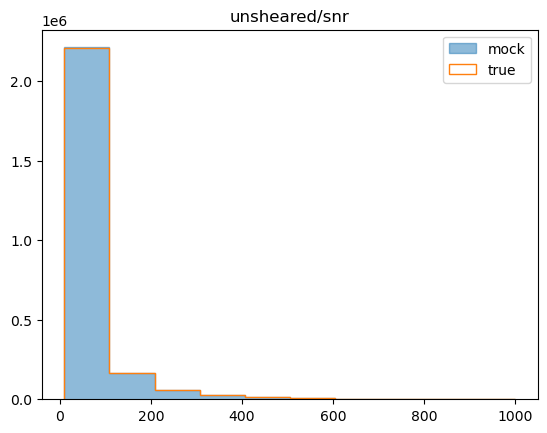

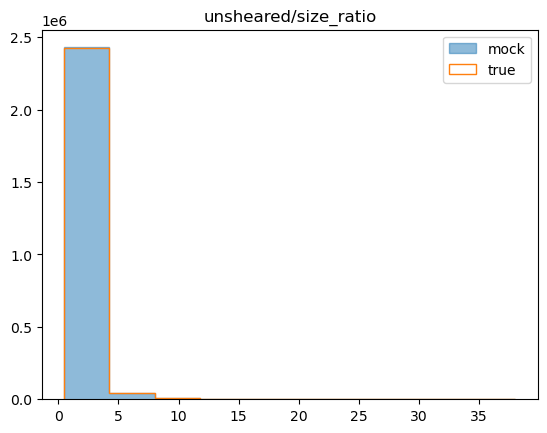

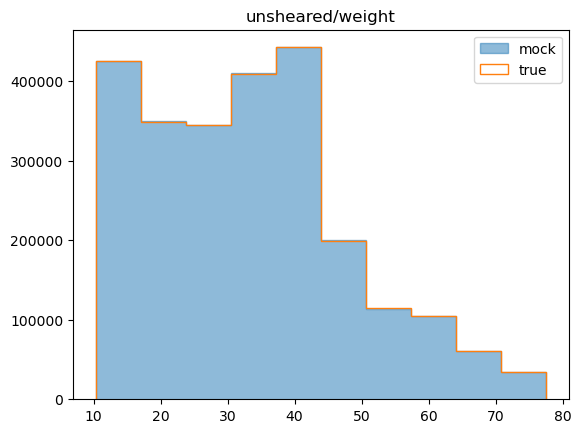

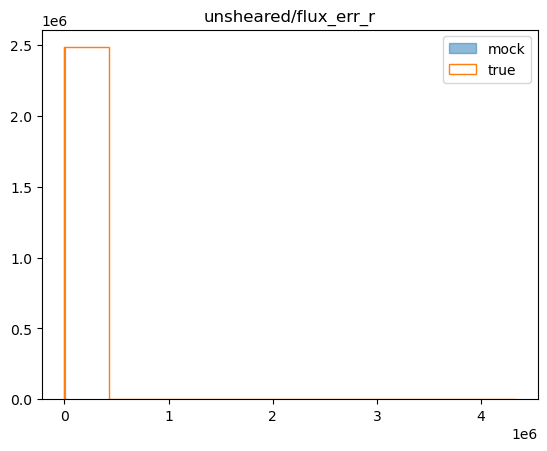

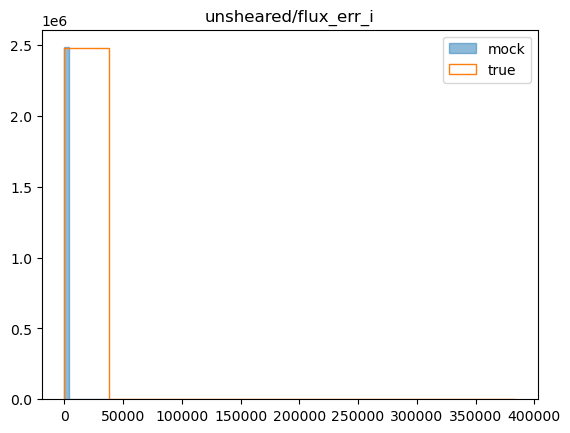

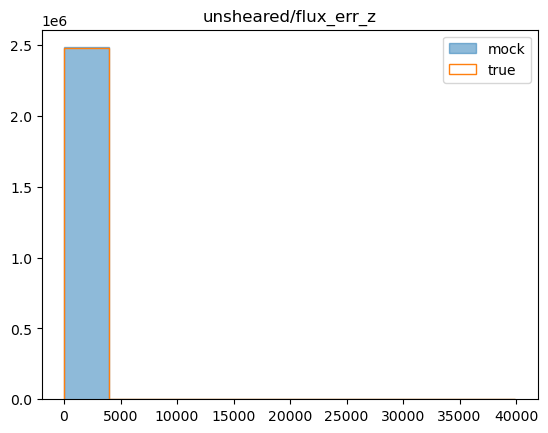

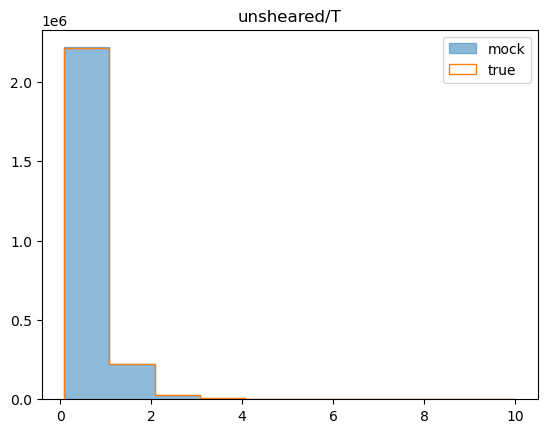

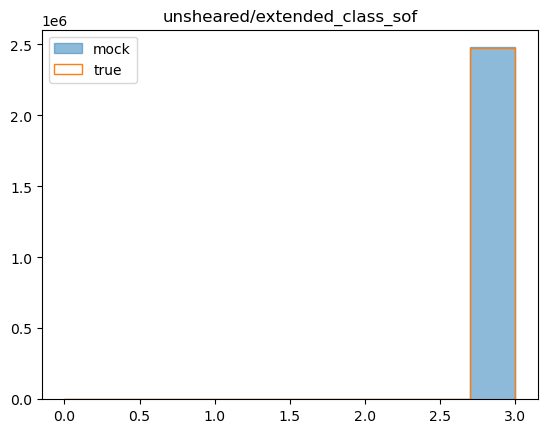

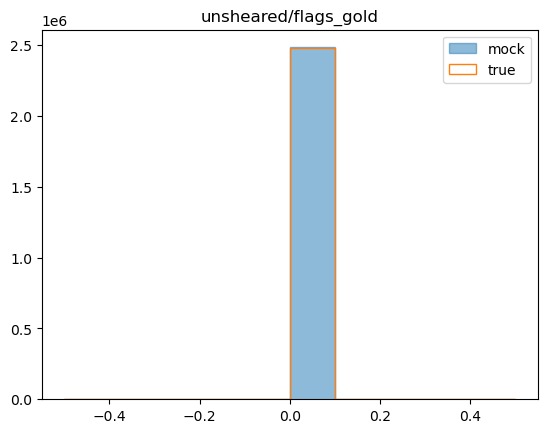

In [127]:
columns = ['unsheared/snr', 'unsheared/size_ratio', 'unsheared/weight', 'unsheared/flux_err_r', 'unsheared/flux_err_i', 'unsheared/flux_err_z', 'unsheared/T', 'unsheared/extended_class_sof', 'unsheared/flags_gold']

for col in columns:
    df_mock = sample_columns(df_balrog=df_snr_prob, df_gandalf=df_mock, column_name=col)
    
    plt.hist(df_mock[col], alpha=0.5, label='mock', fill=True, histtype='step')
    plt.hist(df_snr_prob[col], fill=False, histtype='step', label='true' )
    plt.title(col)
    plt.legend()
    plt.show()


In [128]:
df_balrog = apply_cuts(cfg=cfg, data_frame=df_balrog, mag_cut=False, prob=False)

Apply unsheared object cuts
Length of catalog after applying unsheared object cuts: 8554517
Apply flag cuts
Length of catalog after applying flag cuts: 7375026
Apply unsheared shear cuts
Length of catalog after applying unsheared shear cuts: 2595330
perform binaries cut


/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


len w/ binaries 2595011
define mask
pass:  2483078
fail:  111933


## Use only needed columns

In [129]:
df_balrog = df_balrog[cfg["SOMPZ_COLS"]]
df_mock = df_mock[cfg["SOMPZ_COLS"]]

## Print some statistics

In [130]:
print(df_balrog)
print(df_balrog.isna().sum())
print(df_balrog.isna().sum().sum())

           MAGLIM_R   MAGLIM_I   MAGLIM_Z  FWHM_WMEAN_R  FWHM_WMEAN_I  \
59        24.126900  23.629400  22.924000      1.013690      0.979000   
60        23.782499  23.119101  22.287701      0.964018      0.809270   
61        24.109800  23.256399  22.802500      0.919606      0.815178   
62        24.044600  23.575701  22.604099      0.903751      0.871169   
63        23.589600  23.146099  22.602200      1.042540      0.972417   
...             ...        ...        ...           ...           ...   
26441442  24.222401  23.386499  22.762400      1.027770      1.074130   
26441451  24.033100  23.468901  22.577400      0.987448      0.888688   
26441628  23.914101  23.202400  22.844299      1.043330      0.833140   
26441969  23.747101  23.296301  22.494600      0.904517      0.892719   
26441970  23.962400  23.354300  22.737801      0.905500      0.922269   

          FWHM_WMEAN_Z  AIRMASS_WMEAN_R  AIRMASS_WMEAN_I  AIRMASS_WMEAN_Z  \
59            0.924828          1.08570       

# Get Statistics

## Get the interquartile range if the flux columns and calculate the flux difference between wide and deep flux

In [131]:
df_balrog_flux = df_balrog[cfg["FLUX_COLUMNS"]]
print(df_balrog_flux.shape)
Q1 = df_balrog_flux.quantile(0.25)
Q3 = df_balrog_flux.quantile(0.75)
IQR = Q3 - Q1

df_balrog_flux = df_balrog_flux[~((df_balrog_flux < (Q1 - 1.5 * IQR)) | (df_balrog_flux > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_balrog_flux.shape)
df_balrog_flux = df_balrog_flux.copy()

for bin in cfg["UNSHEARED_BINS"]:
    df_balrog_flux.loc[:, f"flux_diff_{bin}"] = df_balrog_flux[f"unsheared/flux_{bin}"].values - df_balrog_flux[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values

(2483078, 6)
(2126278, 6)


## Plot distribution in i band

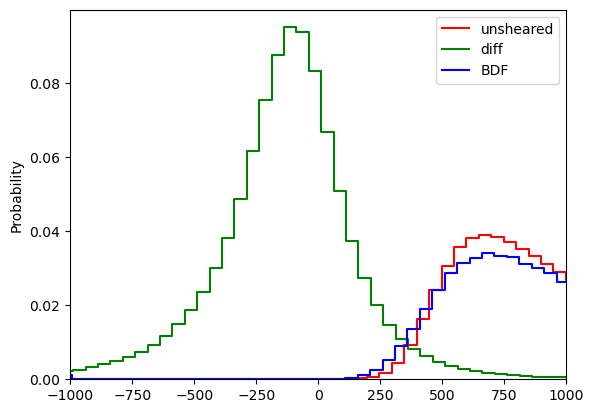

In [132]:
sns.histplot(
    x=df_balrog_flux["unsheared/flux_i"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"unsheared"
)
sns.histplot(
    x=df_balrog_flux["flux_diff_i"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"diff"
)
sns.histplot(
    x=df_balrog_flux["BDF_FLUX_DERED_CALIB_I"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"BDF"
)
plt.xlim(-1000, 1000)
plt.legend()
plt.show()

## Plot difference in all bands

In [133]:
if cfg["PLOT_MOCK_NOISE"] is True:
    plot_histo(
        data_frame=df_balrog_flux,
        columns=cfg["COVARIANCE_COLUMNS"],
        colors=None,
        bin_size=50,
        log_scale=(False, False),
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        xlabel="flux",
        save_name=f"{cfg['PATH_OUTPUT']}/noise_true_hist.png",
        title=f"Noise Histogram"
    )

## Calculate offset

show plot


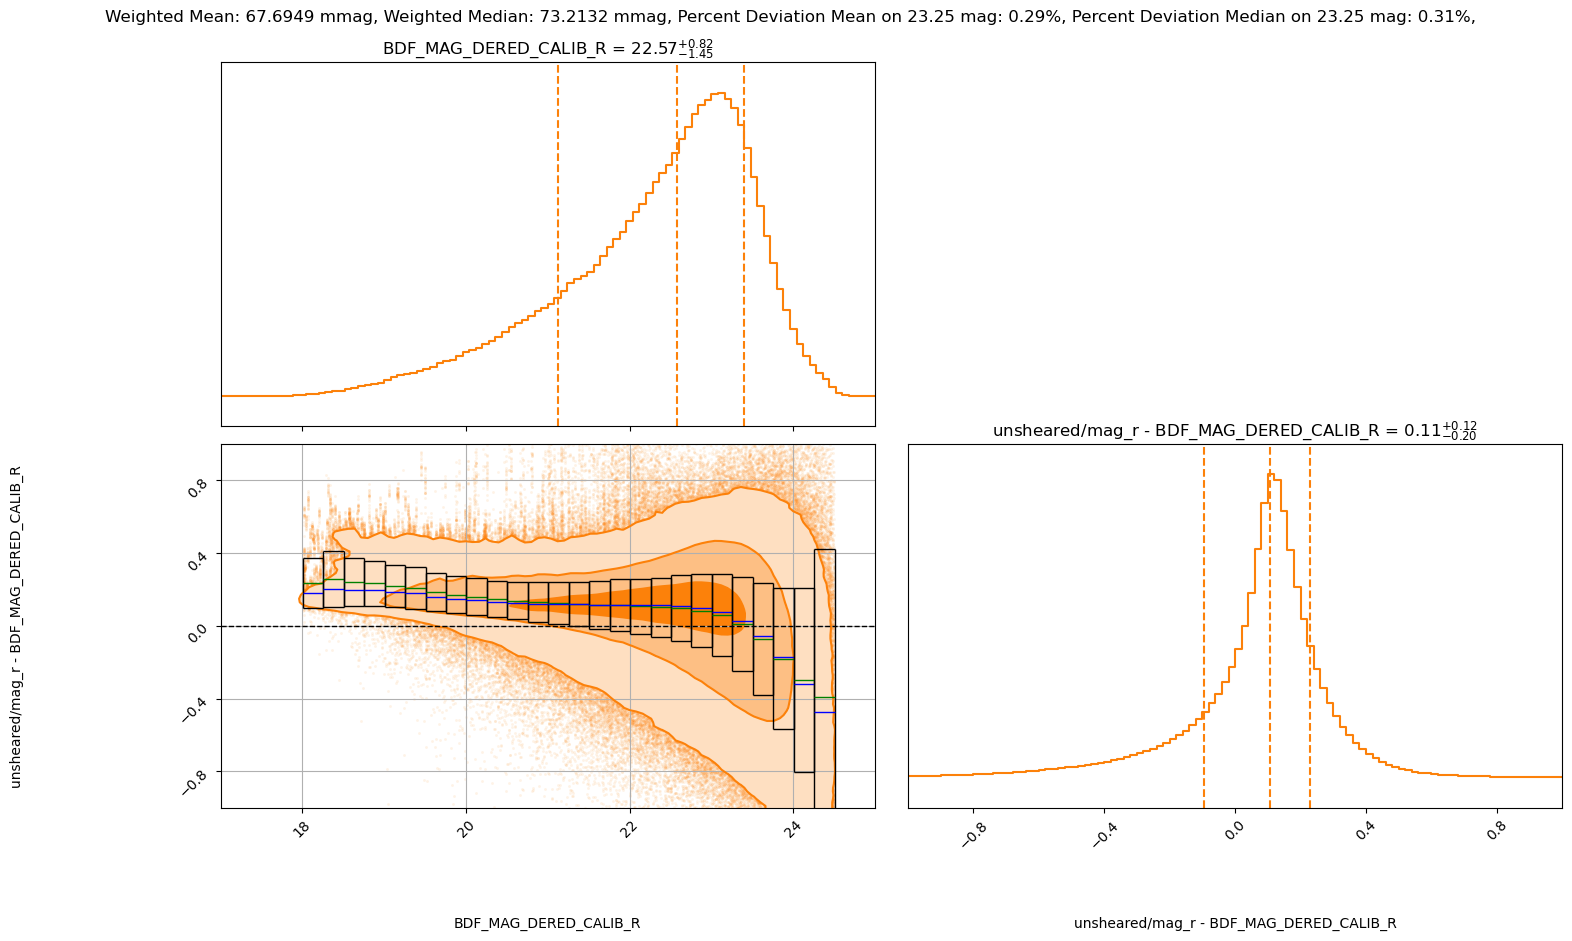

In [134]:
bin_stats_r = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_R",
    measured_column="unsheared/mag_r",
    color="#fc810a",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_r.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

show plot


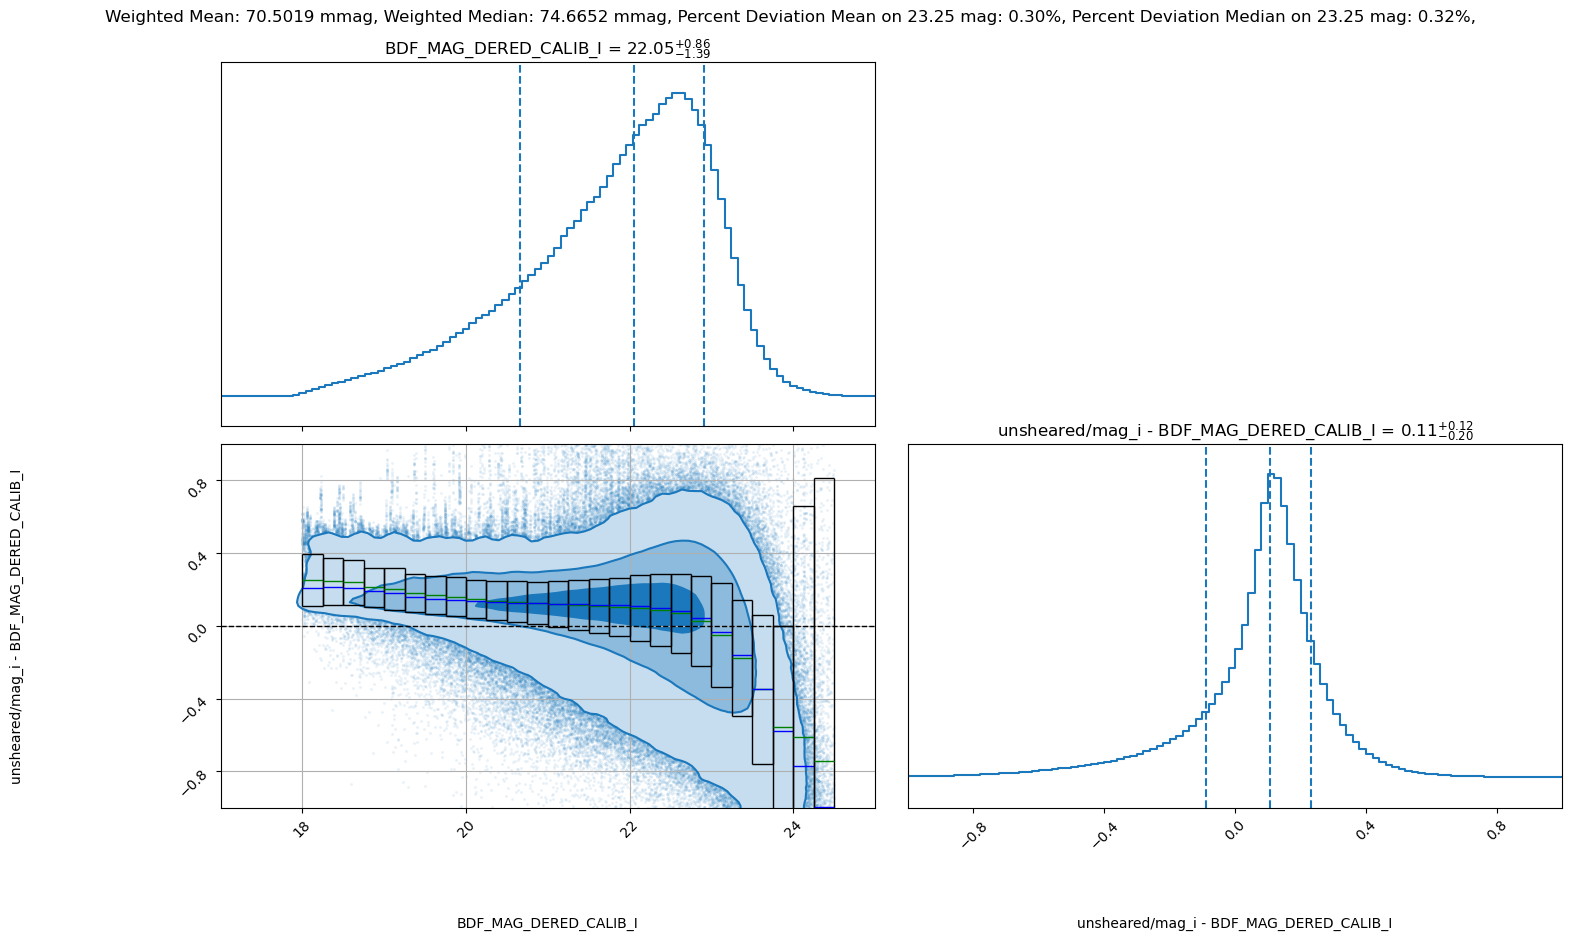

In [135]:

bin_stats_i = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_I",
    measured_column="unsheared/mag_i",
    color="#1b78bc",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_i.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

show plot


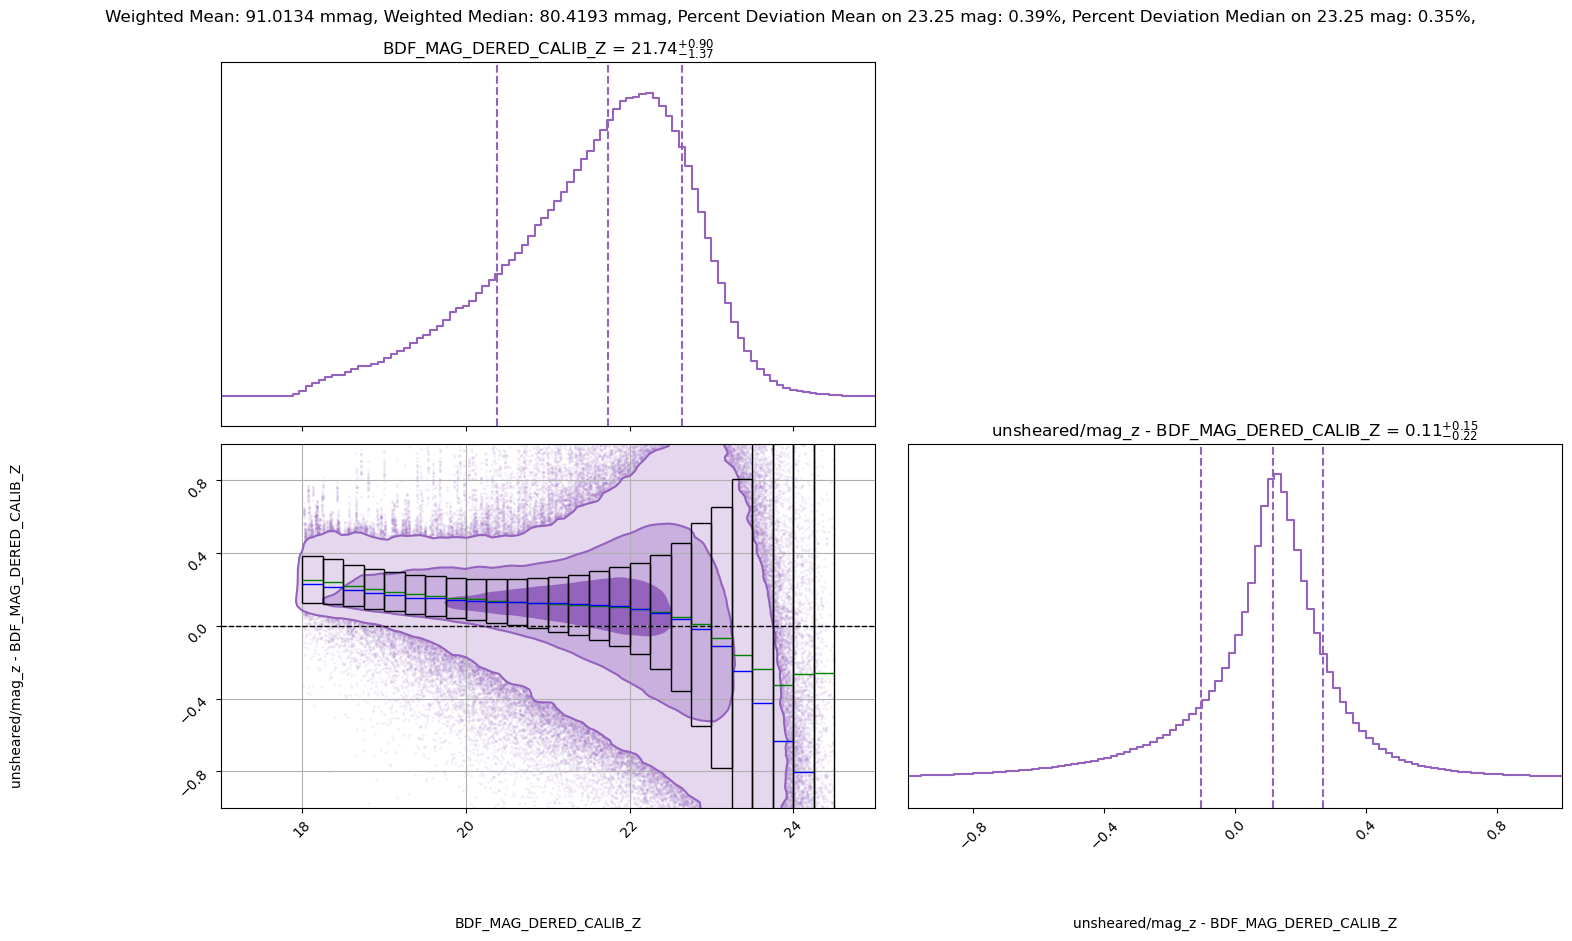

In [136]:

bin_stats_z = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_Z",
    measured_column="unsheared/mag_z",
    color="#9463be",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_z.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

In [137]:
dict_offset = {
        "weighted_mean_mag_r": bin_stats_r['weighted_mean'],
        "weighted_mean_mag_i": bin_stats_i['weighted_mean'],
        "weighted_mean_mag_z": bin_stats_z['weighted_mean'],
        "weighted_median_mag_r": bin_stats_r['weighted_median'],
        "weighted_median_mag_i": bin_stats_i['weighted_median'],
        "weighted_median_mag_z": bin_stats_z['weighted_median'],
        "percent_deviation_mean_r": bin_stats_r['percent_deviation_mean'],
        "percent_deviation_mean_i": bin_stats_i['percent_deviation_mean'],
        "percent_deviation_mean_z": bin_stats_z['percent_deviation_mean'],
        "percent_deviation_median_r": bin_stats_r['percent_deviation_median'],
        "percent_deviation_median_i": bin_stats_i['percent_deviation_median'],
        "percent_deviation_median_z": bin_stats_z['percent_deviation_median']
    }

## Get covariance matrix

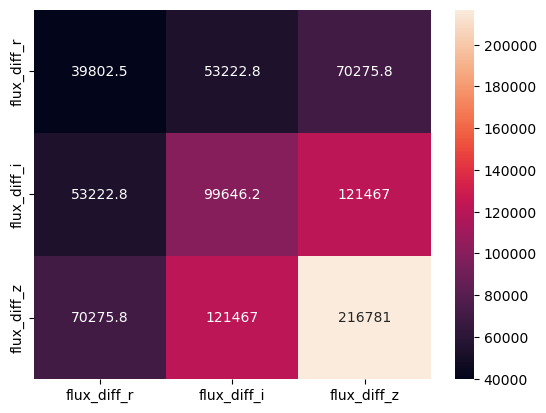

covariance matrix deep distribution: [[ 39802.47106521  53222.76432725  70275.75416013]
 [ 53222.76432725  99646.21168544 121466.98788258]
 [ 70275.75416013 121466.98788258 216781.44729763]]


In [138]:
df_cov_difference = df_balrog_flux[cfg["COVARIANCE_COLUMNS"]]

# Create a DataFrame where each cell is the product of the IQRs of its row and column
cov_matrix_difference = df_cov_difference.cov().values
sns.heatmap(df_cov_difference.cov(), annot=True, fmt='g')
plt.show()

print(f"covariance matrix deep distribution: {cov_matrix_difference}")

## Generate Noise

In [139]:
size = cfg["SIZE_MOCK"]

df_diff = df_balrog_flux[cfg["COVARIANCE_COLUMNS"]]
arr_mean_diff = np.zeros(len(cfg["COVARIANCE_COLUMNS"]))  # df_diff.mean().values

arr_multi_normal_diff = np.random.multivariate_normal(
    arr_mean_diff,
    cov_matrix_difference,
    df_mock.shape[0]
)

## define mock data frame

In [140]:
for idx_col, col in enumerate(cfg["COVARIANCE_COLUMNS"]):
    df_mock[col] = arr_multi_normal_diff[:, idx_col]


## Plot Noise

In [141]:

if cfg["PLOT_MOCK_NOISE"] is True:
    plot_histo(
        data_frame=df_mock,
        columns=cfg["COVARIANCE_COLUMNS"],
        colors=None,
        bin_size=50,
        log_scale=(False, False),
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        xlabel="mag",
        save_name=f"{cfg['PATH_OUTPUT']}/noise_hist.png",
        title=f"Noise Histogram"
    )


## Add noise and offset to deep field flux to get mock flux

In [142]:
for idx_bin, bin in enumerate(cfg["UNSHEARED_BINS"]):
    df_mock[f"unsheared/flux_{bin}"] = df_mock[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values * 10 ** (-0.4 * dict_offset[f"weighted_mean_mag_{bin}"]) + df_mock[f"flux_diff_{bin}"].values

    df_mock[f"unsheared/mag_{bin}"] = flux2mag(df_mock[f"unsheared/flux_{bin}"].values)
    df_mock[f"unsheared/mag_err_{bin}"] = flux2mag(df_mock[f"unsheared/flux_err_{bin}"].values)


## Calculate colors

In [143]:
for idx_bin, bin in enumerate(cfg["UNSHEARED_BINS"]):
    df_mock.loc[:, f"Color unsheared MAG {bin}-{cfg['UNSHEARED_BINS'][idx_bin+1]}"] = (
            df_mock[f"unsheared/mag_{bin}"].values - df_mock[f"unsheared/mag_{cfg['UNSHEARED_BINS'][idx_bin+1]}"].values
    )
    if idx_bin + 1 == len(cfg["UNSHEARED_BINS"]) - 1:
        break

## Reset index

In [144]:
df_mock = df_mock.reset_index(drop=True)
df_true = df_balrog.reset_index(drop=True)

## Add missing columns to mock data frame

In [145]:
# for column in cfg["SOMPZ_COLS"]:
#     if column not in df_mock.columns:
#         df_mock[column] = df_true.loc[df_mock.index, column]
# df_true_sompz_cols = df_true[cfg["SOMPZ_COLS"]]
# Identify columns in df_true that are not in df_mock
# columns_to_merge = df_true.columns.difference(df_mock.columns)

# Merge only those columns from df_true into df_mock
# df_mock = pd.merge(df_mock, df_true[columns_to_merge], left_index=True, right_index=True, how='left')

## Compute injection counts

In [146]:
# df_mock = compute_injection_counts(df_mock)

## Apply mag cuts on separate mock data frame

In [147]:
# df_mock_cut = unsheared_mag_cut(data_frame=df_mock)
df_mock_cut = apply_cuts(cfg=cfg, data_frame=df_mock, mag_cut="only", prob=False)
df_balrog = apply_cuts(cfg=cfg, data_frame=df_balrog, mag_cut="only", prob=False)

Apply unsheared mag cuts
Length of catalog after applying unsheared mag cuts: 2225335
Apply unsheared mag cuts
Length of catalog after applying unsheared mag cuts: 2417633


## Print some statistics

In [148]:
print(f"len mock data: {len(df_mock)}")
print(f"len mock data with cuts: {len(df_mock_cut)}")
print(f"len true data: {len(df_balrog)}")

len mock data: 2485706
len mock data with cuts: 2225335
len true data: 2417633


# Plotting results

## Plot compare flux

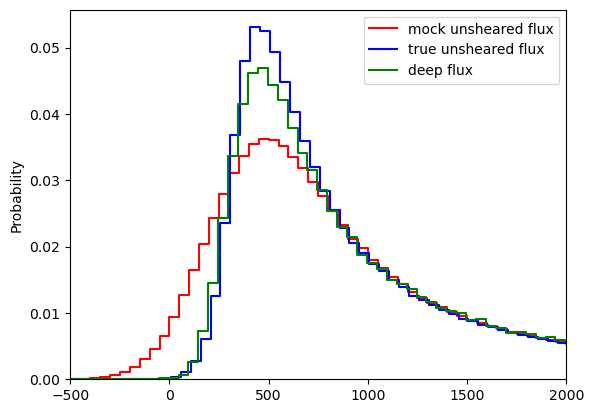

In [149]:
sns.histplot(
    x=df_mock["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"mock unsheared flux"
)
sns.histplot(
    x=df_true["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"true unsheared flux"
)
sns.histplot(
    x=df_true["BDF_FLUX_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"deep flux"
)
plt.xlim(-500, 2000)
plt.legend()
plt.show()

## Plot compare mag

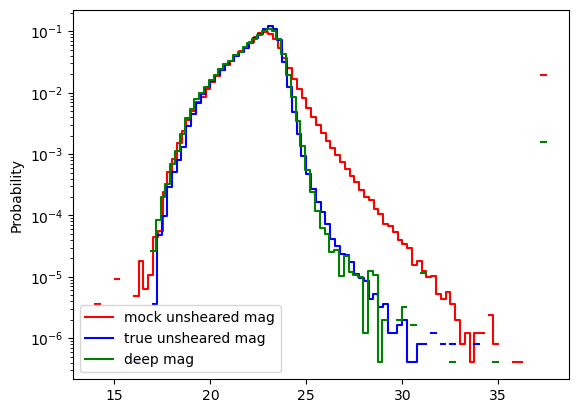

In [150]:
sns.histplot(
    x=df_mock["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"mock unsheared mag"
)
sns.histplot(
    x=df_true["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"true unsheared mag"
)
sns.histplot(
    x=df_true["BDF_MAG_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"deep mag"
)
# plt.xlim(18, 24.5)
plt.legend()
plt.show()

## Plot compare mag only unsheared

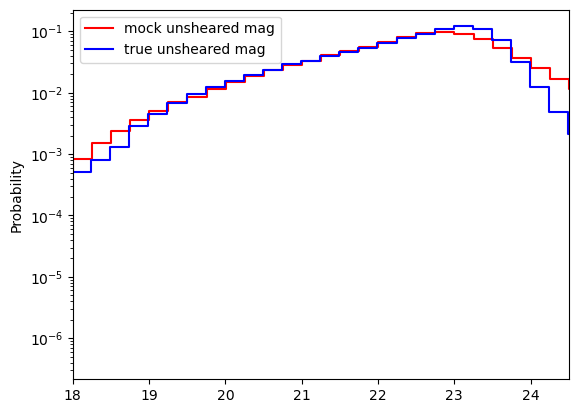

In [151]:
sns.histplot(
    x=df_mock["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"mock unsheared mag"
)
sns.histplot(
    x=df_true["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"true unsheared mag"
)
plt.xlim(18, 24.5)
plt.legend()
plt.show()

## Plot compare mag with mag cuts on mock data frame

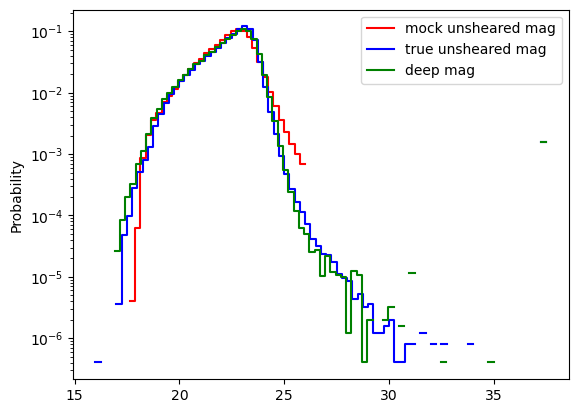

In [152]:
sns.histplot(
    x=df_mock_cut["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"mock unsheared mag"
)
sns.histplot(
    x=df_true["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"true unsheared mag"
)
sns.histplot(
    x=df_true["BDF_MAG_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"deep mag"
)
# plt.xlim(18, 24.5)
plt.legend()
plt.show()

## Plot compare mag with mag cuts on mock data frame only unsheared

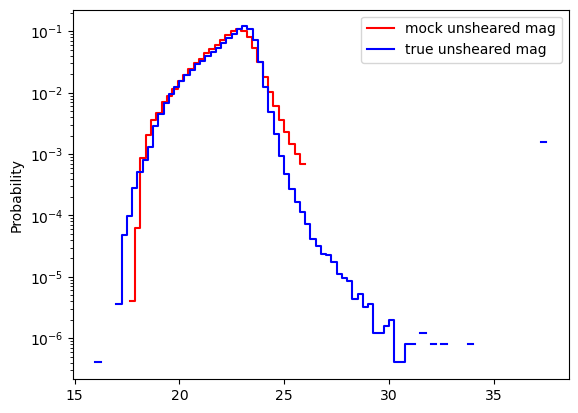

In [153]:
sns.histplot(
    x=df_mock_cut["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"mock unsheared mag"
)
sns.histplot(
    x=df_true["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"true unsheared mag"
)
# plt.xlim(18, 24.5)
plt.legend()
plt.show()

## Plot Mock Offset

In [154]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_mock_cut,
        true_column="BDF_MAG_DERED_CALIB_R",
        measured_column="unsheared/mag_r",
        color="#fc810a",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_mock_after_mag_cuts_r.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )

In [155]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_true,
        true_column="BDF_MAG_DERED_CALIB_R",
        measured_column="unsheared/mag_r",
        color="#fc810a",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_true_after_mag_cuts_r.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )
    

In [156]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_mock_cut,
        true_column="BDF_MAG_DERED_CALIB_I",
        measured_column="unsheared/mag_i",
        color="#1b78bc",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_mock_after_mag_cuts_i.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )
    

In [157]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_true,
        true_column="BDF_MAG_DERED_CALIB_I",
        measured_column="unsheared/mag_i",
        color="#1b78bc",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_true_after_mag_cuts_i.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )
    

In [158]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_mock_cut,
        true_column="BDF_MAG_DERED_CALIB_Z",
        measured_column="unsheared/mag_z",
        color="#9463be",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_mock_after_mag_cuts_z.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )
    

In [159]:
if cfg["PLOT_MOCK_OFFSET"] is True:
    plot_bin_offset(
        data_frame=df_true,
        true_column="BDF_MAG_DERED_CALIB_Z",
        measured_column="unsheared/mag_z",
        color="#9463be",
        save_name=f"{cfg['PATH_OUTPUT']}/offset_true_after_mag_cuts_z.png",
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"]
    )

## Plot compare mag

In [160]:
if cfg["PLOT_COMPARE_MEAS_MAG"] is True:
    plot_compare_corner(
        data_frame_generated=df_mock_cut,
        data_frame_true=df_true,
        columns=[
            "unsheared/mag_r",
            "unsheared/mag_i",
            "unsheared/mag_z",
        ],
        labels=["r", "i", "z"],
        title="True Measured Magnitude",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/compare_meas_mag.png"
    )

## Plot compare flux

In [161]:
if cfg["PLOT_COMPARE_MEAS_FLUX"] is True:
    plot_compare_corner(
        data_frame_generated=df_mock_cut,
        data_frame_true=df_true,
        columns=[
            "unsheared/flux_r",
            "unsheared/flux_i",
            "unsheared/flux_z",
        ],
        labels=["r", "i", "z"],
        title="True Measured Flux",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/compare_meas_flux.png"
    )

## Plot mock mag

In [162]:
if cfg["PLOT_MOCK_MEAS_MAG"] is True:
    plot_corner(
        df_mock_cut,
        columns=[
            "unsheared/mag_r",
            "unsheared/mag_i",
            "unsheared/mag_z",
        ],
        labels=["r", "i", "z"],
        title="True Measured Magnitude",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/mock_meas_mag.png"
    )

## Plot compare color

In [163]:
if cfg["PLOT_COMPARE_MEAS_COLOR"] is True:
    plot_compare_corner(
        data_frame_generated=df_mock_cut,
        data_frame_true=df_true,
        columns=[
            "Color unsheared MAG r-i",
            "Color unsheared MAG i-z"
        ],
        labels=["r-i", "i-z"],
        title="Compare Measured Color",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/compare_meas_color.png"
    )

## Plot mock color

In [164]:

if cfg["PLOT_MOCK_MEAS_COLOR"] is True:
    plot_corner(
        df_mock_cut,
        columns=[
            "Color unsheared MAG r-i",
            "Color unsheared MAG i-z"
        ],
        labels=["r-i", "i-z"],
        title="Mock Measured Color",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/mock_meas_color.png"
    )

## Plot compare histogram mag

In [165]:

if cfg["PLOT_COMPARE_HISTOGRAM_MAG"] is True:
    columns = [
        ["unsheared/mag_r", "BDF_MAG_DERED_CALIB_R"],
        ["unsheared/mag_i", "BDF_MAG_DERED_CALIB_I"],
        ["unsheared/mag_z", "BDF_MAG_DERED_CALIB_Z"]
    ]

    for idx, column in enumerate(columns):
        plot_histo_compare(
            data_frame_generated=df_mock_cut,
            data_frame_true=df_true,
            columns=column,
            colors=[["blue", "green"], ["red", "purple"]],
            bin_size=50,
            log_scale=(False, True),
            show_plot=cfg["SHOW_PLOT_MOCK"],
            save_plot=cfg["SAVE_PLOT_MOCK"],
            xlabel="mag",
            save_name=f"{cfg['PATH_OUTPUT']}/compare_probability_hist_mag_{cfg['UNSHEARED_BINS'][idx]}.png",
            title=f"probability histogram of DES wide field mag {cfg['UNSHEARED_BINS'][idx]}"
        )

## Plot compare histogram error mag

In [166]:
# if cfg["PLOT_COMPARE_HISTOGRAM_MAG_ERR"] is True:
#     columns = [["unsheared/mag_err_r"], ["unsheared/mag_err_i"], ["unsheared/mag_err_z"]]
#     for idx, column in enumerate(columns):
#         plot_histo_compare(
#             data_frame_generated=df_mock_cut,
#             data_frame_true=df_true,
#             columns=column,
#             bin_size=50,
#             log_scale=(False, True),
#             show_plot=cfg["SHOW_PLOT_MOCK"],
#             save_plot=cfg["SAVE_PLOT_MOCK"],
#             xlabel="mag",
#             save_name=f"{cfg['PATH_OUTPUT']}/compare_probability_hist_mag_err_{cfg['UNSHEARED_BINS'][idx]}.png",
#             title=f"probability histogram of DES wide field mag err {cfg['UNSHEARED_BINS'][idx]}"
#         )

## Plot compare histogram flux

In [167]:
if cfg["PLOT_COMPARE_HISTOGRAM_FLUX"] is True:
    columns = [["unsheared/flux_r"], ["unsheared/flux_i"], ["unsheared/flux_z"]]
    for idx, column in enumerate(columns):
        plot_histo_compare(
            data_frame_generated=df_mock_cut,
            data_frame_true=df_true,
            columns=column,
            bin_size=50,
            log_scale=(False, False),
            show_plot=cfg["SHOW_PLOT_MOCK"],
            save_plot=cfg["SAVE_PLOT_MOCK"],
            xlabel="flux",
            save_name=f"{cfg['PATH_OUTPUT']}/compare_probability_hist_flux_{cfg['UNSHEARED_BINS'][idx]}.png",
            title=f"probability histogram of DES wide field flux {cfg['UNSHEARED_BINS'][idx]}"
        )

## Plot compare histogram error flux

In [168]:
# if cfg["PLOT_COMPARE_HISTOGRAM_FLUX_ERR"] is True:
#     columns = [["unsheared/flux_err_r"], ["unsheared/flux_err_i"], ["unsheared/flux_err_z"]]
#     for idx, column in enumerate(columns):
#         plot_histo_compare(
#             data_frame_generated=df_mock,
#             data_frame_true=df_true,
#             columns=column,
#             bin_size=50,
#             log_scale=(False, False),
#             show_plot=cfg["SHOW_PLOT_MOCK"],
#             save_plot=cfg["SAVE_PLOT_MOCK"],
#             xlabel="flux",
#             save_name=f"{cfg['PATH_OUTPUT']}/compare_probability_hist_flux_err_{cfg['UNSHEARED_BINS'][idx]}.png",
#             title=f"probability histogram of DES wide field flux err {cfg['UNSHEARED_BINS'][idx]}"
#         )

In [169]:
print(len(df_mock_cut))
for k in df_mock_cut.keys():
    print(k)

2225335
MAGLIM_R
MAGLIM_I
MAGLIM_Z
FWHM_WMEAN_R
FWHM_WMEAN_I
FWHM_WMEAN_Z
AIRMASS_WMEAN_R
AIRMASS_WMEAN_I
AIRMASS_WMEAN_Z
BDF_G
BDF_T
EBV_SFD98
BDF_MAG_DERED_CALIB_R
BDF_MAG_DERED_CALIB_I
BDF_MAG_DERED_CALIB_Z
BDF_MAG_ERR_DERED_CALIB_R
BDF_MAG_ERR_DERED_CALIB_I
BDF_MAG_ERR_DERED_CALIB_Z
BDF_FLUX_DERED_CALIB_R
BDF_FLUX_DERED_CALIB_I
BDF_FLUX_DERED_CALIB_Z
Color BDF MAG U-G
Color BDF MAG G-R
Color BDF MAG R-I
Color BDF MAG I-Z
Color BDF MAG Z-J
Color BDF MAG J-H
Color BDF MAG H-K
Color unsheared MAG r-i
Color unsheared MAG i-z
unsheared/mag_r
unsheared/mag_i
unsheared/mag_z
unsheared/mag_err_r
unsheared/mag_err_i
unsheared/mag_err_z
unsheared/flux_r
unsheared/flux_i
unsheared/flux_z
unsheared/flux_err_r
unsheared/flux_err_i
unsheared/flux_err_z
unsheared/T
unsheared/weight
unsheared/size_ratio
unsheared/snr
unsheared/extended_class_sof
unsheared/flags_gold
match_flag_1.5_asec
flags_foreground
flags_badregions
flags_footprint
true_id
bal_id
injection_counts
flux_diff_r
flux_diff_i
flux_di

In [170]:
filename = f"{cfg['RUN_DATE']}_{cfg['FILENAME_MOCK_CAT']}_{len(df_mock_cut)}"
print(f"Saving file as HDF5 with name: {filename}")
df_mock.to_hdf(f"{cfg['PATH_OUTPUT']}/Catalogs/{filename}.h5", key='df', mode='w')

Saving file as HDF5 with name: 2024-02-21_08-05_balrog_mock_2225335
